In [1]:
%matplotlib inline

In [2]:
from __future__ import division
from __future__ import print_function

In [3]:
import numpy as np
import matplotlib.pyplot as plt

from scipy import ndimage
from scipy.spatial import distance

DEBUG:PIL.PngImagePlugin:STREAM IHDR 16 13
DEBUG:PIL.PngImagePlugin:STREAM pHYs 41 9
DEBUG:PIL.PngImagePlugin:STREAM gAMA 62 4
DEBUG:PIL.PngImagePlugin:STREAM cHRM 78 32
DEBUG:PIL.PngImagePlugin:cHRM 78 32 (unknown)
DEBUG:PIL.PngImagePlugin:STREAM IDAT 122 70981


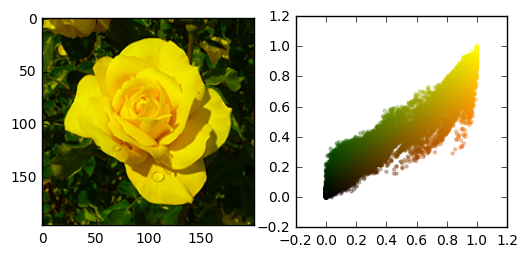

In [5]:
img = ndimage.io.imread('12-Rosa_Gold_Glow_2_small_noblue.png')/255.

plt.subplot(121)
plt.imshow(img)

im_flat = img.reshape([-1, 3])
plt.subplot(122)
plt.scatter(im_flat[:,0], im_flat[:,1], c=im_flat, marker='.', edgecolors='face', alpha=0.3)
plt.axis('square')
None

In [6]:
# use K-means to quantize the colors

In [7]:
N, D = im_flat.shape

Iteration: 0 Loss: 208.851
Iteration: 10 Loss: 144.966
Iteration: 20 Loss: 109.49
Iteration: 30 Loss: 99.4332
Iteration: 40 Loss: 96.7178
Iteration: 50 Loss: 95.1371
Iteration: 60 Loss: 93.9064
Iteration: 70 Loss: 88.5772
Iteration: 80 Loss: 82.2498
Iteration: 90 Loss: 81.2755
Iteration: 100 Loss: 80.5995
Iteration: 110 Loss: 80.1836
Iteration: 120 Loss: 79.0943
Iteration: 130 Loss: 78.5385
Iteration: 140 Loss: 77.6599
Iteration: 150 Loss: 76.642
Iteration: 160 Loss: 76.3078
Iteration: 170 Loss: 75.7843
Iteration: 180 Loss: 75.3257
Iteration: 190 Loss: 75.2624
Iteration: 200 Loss: 75.2332


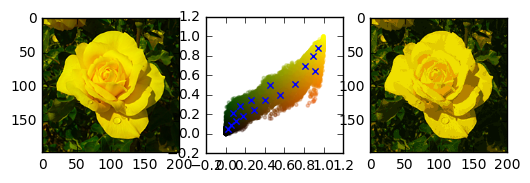

In [13]:
K = 16
initiali_center_ids = np.random.choice(N, (K,), replace=False)
centers = im_flat[initiali_center_ids, :]

old_loss = np.inf
for i in range(10000):
    center_to_cluster_dists = distance.cdist(centers, im_flat)
    cluster_assignment = np.argmin(center_to_cluster_dists, axis=0)
    for k in xrange(K):
        centers[k] = im_flat[cluster_assignment==k].mean(axis=0)
    loss = ((centers[cluster_assignment] - im_flat)**2).sum()
    if not i%10:
        print ("Iteration: %d Loss: %g" % (i, loss))
    if loss >= old_loss:
        break
    old_loss = loss

plt.subplot(131)
plt.imshow(img)

plt.subplot(132)
plt.scatter(im_flat[:,0], im_flat[:,1], c=im_flat, marker='.', edgecolors='face', alpha=0.3)
plt.scatter(centers[:,0], centers[:,1], marker='x')
plt.axis('square')

plt.subplot(133)
center_to_cluster_dists = distance.cdist(centers, im_flat)
cluster_assignment = np.argmin(center_to_cluster_dists, axis=0)
plt.imshow(centers[cluster_assignment].reshape(img.shape))

Iteration: 0 Loss: 1682.63
Iteration: 100000 Loss: 140.971
Iteration: 200000 Loss: 141.032
Iteration: 300000 Loss: 141.969
Iteration: 400000 Loss: 141.236
Iteration: 500000 Loss: 141.376
Iteration: 600000 Loss: 140.922
Iteration: 700000 Loss: 140.813
Iteration: 800000 Loss: 140.714
Iteration: 900000 Loss: 140.876


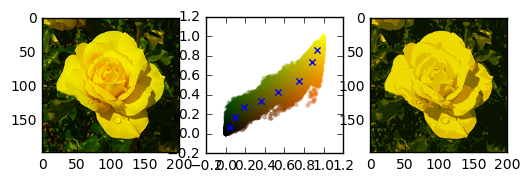

In [14]:
# An on-line version of k-Means

K = 8
initiali_center_ids = np.random.choice(N, (K,), replace=False)
centers = im_flat[initiali_center_ids, :]

alpha = 1e-2
for i in range(1000000):
    sampled_x = im_flat[np.random.randint(N)]
    cluster_id = np.argmin(((centers - sampled_x)**2).sum(axis=1))
    centers[cluster_id] = (1 - alpha) * centers[cluster_id] + alpha * sampled_x
    
    if not i%100000:
        center_to_cluster_dists = distance.cdist(centers, im_flat)
        cluster_assignment = np.argmin(center_to_cluster_dists, axis=0)
        loss = ((centers[cluster_assignment] - im_flat)**2).sum()
        print ("Iteration: %d Loss: %g" % (i, loss))
    
plt.subplot(131)
plt.imshow(img)

plt.subplot(132)
plt.scatter(im_flat[:,0], im_flat[:,1], c=im_flat, marker='.', edgecolors='face', alpha=0.3)
plt.scatter(centers[:,0], centers[:,1], marker='x')
plt.axis('square')

plt.subplot(133)
center_to_cluster_dists = distance.cdist(centers, im_flat)
cluster_assignment = np.argmin(center_to_cluster_dists, axis=0)
plt.imshow(centers[cluster_assignment].reshape(img.shape))

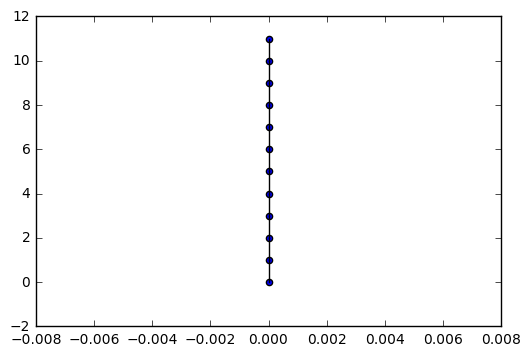

In [18]:
# Kohonen map

# First create a topology between units.
# This has nothing to do with the data we want to quantize!

NY, NX = np.meshgrid(np.arange(1), np.arange(12))
neuron_topology = np.stack([NY.ravel(), NX.ravel()], axis=1)

K = neuron_topology.shape[0]

C = np.zeros((K, K))
for ni in xrange(K):
    for nj in xrange(K):
        C[ni, nj] = np.maximum(0.0, 
                               1.0 - np.abs(neuron_topology[ni] - neuron_topology[nj]).sum()/2.0)

def plot_lines(C, locations, **kwargs):
    segments = []
    for ni, nj in zip(*np.nonzero(C)):
        if ni < nj:
            segments.append(locations[ni])
            segments.append(locations[nj])
            segments.append(np.zeros((2,)) + np.nan)
    segments = np.array(segments)
    plt.plot(segments[:,0], segments[:,1], **kwargs)

plt.scatter(neuron_topology[:,0], neuron_topology[:,1])
plot_lines(C, neuron_topology, color='k')

In [19]:
C

Shape: (12, 12)
[[ 1.   0.5  0.   0.   0.   0.   0.   0.   0.   0.   0.   0. ]
 [ 0.5  1.   0.5  0.   0.   0.   0.   0.   0.   0.   0.   0. ]
 [ 0.   0.5  1.   0.5  0.   0.   0.   0.   0.   0.   0.   0. ]
 [ 0.   0.   0.5  1.   0.5  0.   0.   0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.5  1.   0.5  0.   0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   0.5  1.   0.5  0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   0.   0.5  1.   0.5  0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   0.   0.   0.5  1.   0.5  0.   0.   0. ]
 [ 0.   0.   0.   0.   0.   0.   0.   0.5  1.   0.5  0.   0. ]
 [ 0.   0.   0.   0.   0.   0.   0.   0.   0.5  1.   0.5  0. ]
 [ 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.5  1.   0.5]
 [ 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.5  1. ]]

Iteration: 0 Loss: 245.443
Iteration: 100000 Loss: 107.516
Iteration: 200000 Loss: 108.31
Iteration: 300000 Loss: 111.678
Iteration: 400000 Loss: 108.138
Iteration: 500000 Loss: 108.047
Iteration: 600000 Loss: 108.477
Iteration: 700000 Loss: 110.25
Iteration: 800000 Loss: 109.927
Iteration: 900000 Loss: 108.714
Iteration: 1000000 Loss: 108.926
Iteration: 1100000 Loss: 110.519
Iteration: 1200000 Loss: 110.761
Iteration: 1300000 Loss: 109.7
Iteration: 1400000 Loss: 112.125
Iteration: 1500000 Loss: 110.404
Iteration: 1600000 Loss: 108.521
Iteration: 1700000 Loss: 109.367
Iteration: 1800000 Loss: 108.941
Iteration: 1900000 Loss: 109.861
Iteration: 2000000 Loss: 110.771
Iteration: 2100000 Loss: 110.752
Iteration: 2200000 Loss: 109.069
Iteration: 2300000 Loss: 109.706
Iteration: 2400000 Loss: 110.638
Iteration: 2500000 Loss: 107.484
Iteration: 2600000 Loss: 109.456
Iteration: 2700000 Loss: 109.269
Iteration: 2800000 Loss: 111.237
Iteration: 2900000 Loss: 110.266


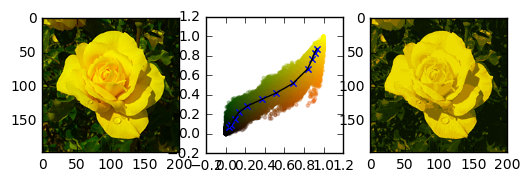

In [20]:
# Kohonen map

# First create a topology between units.
# This has nothing to do with the data we want to quantize!

initiali_center_ids = np.random.choice(N, (K,), replace=False)
centers = im_flat[initiali_center_ids, :]

alpha = 2e-2
for i in range(3000000):
    sampled_x = im_flat[np.random.randint(N)]
    cluster_id = np.argmin(((centers - sampled_x)**2).sum(axis=1))
    cluster_alpha = (alpha * C[cluster_id]).reshape([-1, 1])
    centers = (1 - cluster_alpha) * centers + cluster_alpha * sampled_x
    
    if not i%100000:
        center_to_cluster_dists = distance.cdist(centers, im_flat)
        cluster_assignment = np.argmin(center_to_cluster_dists, axis=0)
        loss = ((centers[cluster_assignment] - im_flat)**2).sum()
        print ("Iteration: %d Loss: %g" % (i, loss))
    
plt.subplot(131)
plt.imshow(img)

plt.subplot(132)
plt.scatter(im_flat[:,0], im_flat[:,1], c=im_flat, marker='.', edgecolors='face', alpha=0.3)
plt.scatter(centers[:,0], centers[:,1], marker='x')
plot_lines(C, centers[:,:2], color='k')
plt.axis('square')

plt.subplot(133)
center_to_cluster_dists = distance.cdist(centers, im_flat)
cluster_assignment = np.argmin(center_to_cluster_dists, axis=0)
plt.imshow(centers[cluster_assignment].reshape(img.shape))

(-0.20000000000000001,
 1.2000000000000002,
 -0.20000000000000001,
 1.2000000000000002)

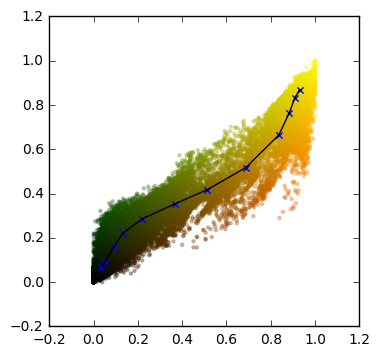

In [21]:
plt.scatter(im_flat[:,0], im_flat[:,1], c=im_flat, marker='.', edgecolors='face', alpha=0.3)
plt.scatter(centers[:,0], centers[:,1], marker='x')
plot_lines(C, centers[:,:2], color='k')
plt.axis('square')